In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve, average_precision_score
from IPython.display import Latex

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

secilen_sutunlar = ["WeekDay", "DayHour", "Humidity", "Temperature", "Light", "CO2", "Feature1"]
tum_degerler_dosya_adi = "TumSutunlar"
decision_tree_dosya_adi = "dt"

## Data Loading

First, let's read our data into three pandas dataframes named **training_df, test_df, test2_df** and then we concatenate our dataframes into one called **tum_df**.

When we look at the data, we see a column contains *datetime* objects called date and four other columns contain *float* values and finally our *label* column called *Occupancy* contains *integer* values **0 and 1** symbolizing if there is human in the room or not.

For checking if there is a missing value on the data and learning more information on the data we called pandas' **describe** method on the tum_df dataframe. So, we will have some insights about data's distribution.

In [2]:
training_df = pd.read_csv("datatraining.txt")
test_df = pd.read_csv("datatest.txt")
test2_df = pd.read_csv("datatest2.txt")

tum_df = pd.concat([training_df, test_df, test2_df])

tum_df.head(5)

,Date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
tum_df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


## Converting Dates

The *Date* column at our hands is actually a string type column, which means it has no use on machine learning algorithms. In this case we can convert this date column to integer values. In fact, we may have better results if we produce two different features called **day of the week and hour of the day**. Because of each value on the date column is being unique, I think the algorithm can predict more generally if we create these two features, as the algorithm may find the work days and the work hours in these features. Because nobody works in the office on weekends and off work hours we can predict that there will be no one.

**Note: ** For the future graphic errors, we sort the data by Date column. We are doing this because when we concatenate the data in the order of train, test and test2, the actual date distributions of these datas are different order. So, we are making sure that our full data in a time series sequence...

In [4]:
sutun_sirasi = ["Date", "WeekDay", "DayHour", "Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Feature1", "Occupancy"]
sonuc_legend = ["Training Score", "Test Score", "Test-2 Score"]

tum_df["Date"] = pd.to_datetime(tum_df.Date)
tum_df = tum_df.sort_values("Date")
tum_df = tum_df.reset_index(drop=True)
tum_df["WeekDay"] = tum_df.Date.dt.dayofweek
tum_df["DayHour"] = pd.to_numeric((tum_df.Date.dt.strftime("%H:%M")).str.replace(":",""))
tum_df["Feature1"] = np.log(tum_df.HumidityRatio**0.2 + (tum_df.DayHour+1)**0.1)*1000
tum_df = tum_df[sutun_sirasi]

test2_df["Date"] = pd.to_datetime(test2_df.Date)
test2_df = test2_df.sort_values("Date")
test2_df = test2_df.reset_index(drop=True)
test2_df["WeekDay"] = test2_df.Date.dt.dayofweek
test2_df["DayHour"] = pd.to_numeric((test2_df.Date.dt.strftime("%H:%M")).str.replace(":",""))
test2_df["Feature1"] = np.log(test2_df.HumidityRatio**0.2 + (test2_df.DayHour+1)**0.1)*1000
test2_df = test2_df[sutun_sirasi]

tum_df.head()

,Date,WeekDay,DayHour,Temperature,Humidity,Light,CO2,HumidityRatio,Feature1,Occupancy
0,2015-02-02 14:19:00,0,1419,23.7000,26.272,585.200000,749.200000,0.004764,879.505687,1
1,2015-02-02 14:19:59,0,1419,23.7180,26.290,578.400000,760.400000,0.004773,879.556465,1
2,2015-02-02 14:21:00,0,1421,23.7300,26.230,572.666667,769.666667,0.004765,879.632302,1
3,2015-02-02 14:22:00,0,1422,23.7225,26.125,493.750000,774.750000,0.004744,879.564556,1
4,2015-02-02 14:23:00,0,1423,23.7540,26.200,488.600000,779.000000,0.004767,879.761449,1


## Finding Correlations and Visualizing The Data

First we must draw *Correlation Matrix* to find correlations each feature and label and also between the features. We try to find out maximum correlation between a feature and label and also minimum correlation between each feature, so that, we can eliminate similar features that basicly give the same results to us and can select maximum useful features for training our models.

With the correlation matrix we find some interesting correlations between:
* Light - Occupancy
* CO2 - Occupancy
* Temperature - Occupancy
* DayHour - Occupancy
* Humidity - HumidityRatio **(Not from correlation matrix)**

Humidity and HumidityRatio are basicly the same values, we can tell that by looking at the graphics below and also the names of the features can give a hint. :) That means, it is needless to give both of them to the model, because they are giving basicly the same information, so we can choose one of them to decrease dimension size to be learned by our models. This will decrease required computational power and fitting time and also complexity of our model.

There is also strong correlation between Light - Occupancy, CO2 - Occupancy and Temperature - Occupancy which means we must definitely choose Light, CO2 and Temperature features to train our models. This may be explained by humans turning the lights on and producing CO2 and Temperature in the office.

Interesting thing about the correlation matrix is that the DayHour feature which we previously extracted have little effect on Occupancy, opposite to our way of thinking about work hours. Regardless, I will keep it because it certainly gives us more clue than Humidity.

There is also a significant correlation between Occupancy and Feature1 and reverse correlation between WeekDay and Occupancy which are features that we extracted earlier. So, I will keep them as well...

In [5]:
tum_degerler = []
#secilen_sutunlar = ["HumidityRatio", "Temperature", "Light", "CO2"]

tum_X = tum_df[secilen_sutunlar]
tum_y = tum_df.Occupancy

test2_X = test2_df[secilen_sutunlar]
test2_y = test2_df.Occupancy

train_X, test_X, train_y, test_y = train_test_split(tum_X, tum_y, test_size=0.3, random_state=42)

train_X.join(train_y).corr()

,WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1,Occupancy
WeekDay,1.000000,-0.007702,-0.045967,-0.240769,-0.187515,-0.466189,-0.010148,-0.283337
DayHour,-0.007702,1.000000,0.118822,0.233841,0.096450,0.122599,0.861178,0.105168
Humidity,-0.045967,0.118822,1.000000,-0.152293,-0.022005,0.302273,0.136484,0.055210
Temperature,-0.240769,0.233841,-0.152293,1.000000,0.690611,0.447296,0.295535,0.557308
Light,-0.187515,0.096450,-0.022005,0.690611,1.000000,0.448874,0.245562,0.915901
CO2,-0.466189,0.122599,0.302273,0.447296,0.448874,1.000000,0.190651,0.502625
Feature1,-0.010148,0.861178,0.136484,0.295535,0.245562,0.190651,1.000000,0.228639
Occupancy,-0.283337,0.105168,0.055210,0.557308,0.915901,0.502625,0.228639,1.000000


Text(0,0.5,'Occupancy')

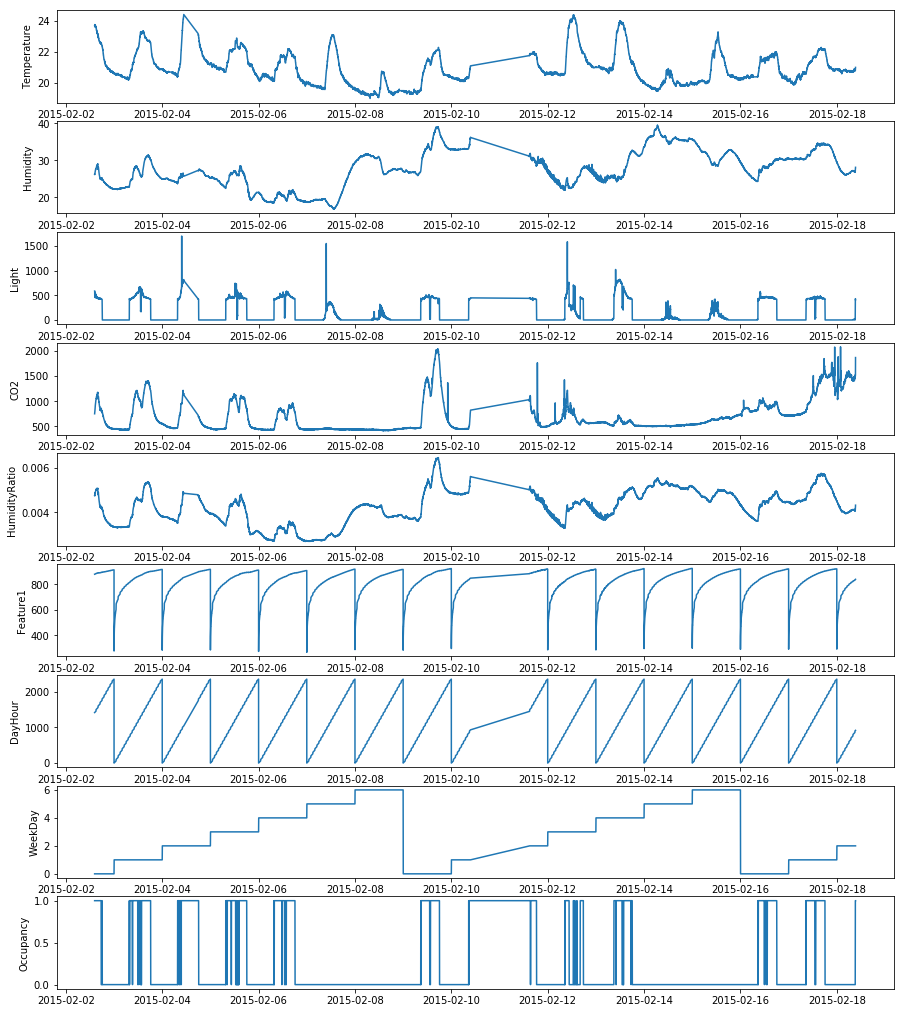

In [6]:
%matplotlib inline

fig, ax = plt.subplots(9, 1, figsize=(15, 18))
ax[0].plot(tum_df.Date, tum_df.Temperature)
ax[0].set_ylabel("Temperature")
ax[1].plot(tum_df.Date, tum_df.Humidity)
ax[1].set_ylabel("Humidity")
ax[2].plot(tum_df.Date, tum_df.Light)
ax[2].set_ylabel("Light")
ax[3].plot(tum_df.Date, tum_df.CO2)
ax[3].set_ylabel("CO2")
ax[4].plot(tum_df.Date, tum_df.HumidityRatio)
ax[4].set_ylabel("HumidityRatio")
ax[5].plot(tum_df.Date, tum_df.Feature1)
ax[5].set_ylabel("Feature1")
ax[6].plot(tum_df.Date, tum_df.DayHour)
ax[6].set_ylabel("DayHour")
ax[7].plot(tum_df.Date, tum_df.WeekDay)
ax[7].set_ylabel("WeekDay")
ax[8].plot(tum_df.Date, tum_df.Occupancy)
ax[8].set_ylabel("Occupancy")

There is something awkward about the data which occurs on the date *2015-02-11*. So, I grouped the data by dates and hours.

I find what the problem is about. There is a time gap between **February $10^{th}$** and  **February $11^{th}$**.

In this particular problem, we can choose either filling the blanks or omit it all. I have chosen omitting this problem for I am taking the day of the week and hour of the day values, not the date itself. So, I think it won't be a problem for me.

In [7]:
on_on1_df = tum_df[tum_df.Date.dt.day.isin([10, 11])]
display(on_on1_df.groupby([on_on1_df.Date.dt.day, on_on1_df.Date.dt.hour]).count())

Date  WeekDay  DayHour  Temperature  Humidity  Light  CO2  \
Date Date                                                              
10   0       60       60       60           60        60     60   60   
     1       61       61       61           61        61     61   61   
     2       59       59       59           59        59     59   59   
     3       60       60       60           60        60     60   60   
     4       61       61       61           61        61     61   61   
     5       59       59       59           59        59     59   59   
     6       60       60       60           60        60     60   60   
     7       61       61       61           61        61     61   61   
     8       59       59       59           59        59     59   59   
     9       34       34       34           34        34     34   34   
11   14      12       12       12           12        12     12   12   
     15      60       60       60           60        60     60   60   
     16      61       61       61           61        61     61   61   
     17      59       59       59           59        59     59   59   
     18      60       60       60           60        60     60   60   
     19      61       61       61           61        61     61   61   
     20      59       59       59           59        59     59   59   
     21      60       60       60           60        60     60   60   
     22      61       61       61           61        61     61   61   
     23      59       59       59           59        59     59   59   

           HumidityRatio  Feature1  Occupancy  
Date Date                                      
10   0                60        60         60  
     1                61        61         61  
     2                59        59         59  
     3                60        60         60  
     4                61        61         61  
     5                59        59         59  
     6                60        60         60  
     7                61        61         61  
     8                59        59         59  
     9                34        34         34  
11   14               12        12         12  
     15               60        60         60  
     16               61        61         61  
     17               59        59         59  
     18               60        60         60  
     19               61        61         61  
     20               59        59         59  
     21               60        60         60  
     22               61        61         61  
     23               59        59         59

## Data Distributions on Each Datasets

With the sklearn's train_test_split function, we split our full data into new training and testing datasets, and because this report will be graded for the test2 dataset, we also take that dataset too. **But we musn't forget that we combine datas all together, so even we split our data into training and testing datasets, they can have a lot of information from test2 dataset. This will make our predictions unreliable. So, I will score the algorithms with both of the test datas, but only reliable scores will be the test scores, for training data will not contain any information from it...**

To control our datasets label distributions are similar, we draw histograms on each of the datasets. As we can see from the histograms, our label distributions on the datasets are similar, which means our dataset are distributed about the same ratio. This makes our models more accurate.

Text(0.5,1,'Test2 Labels')

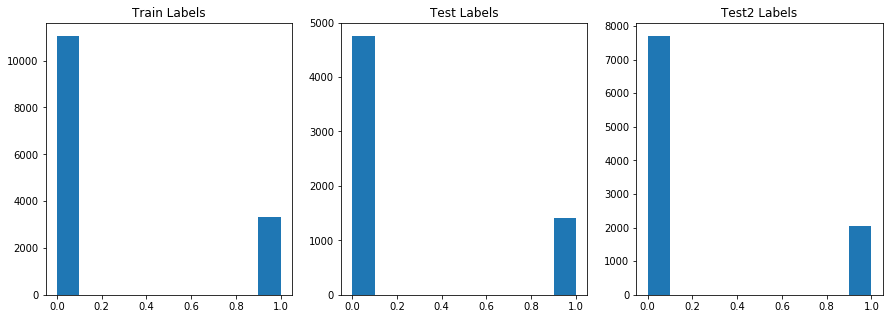

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout=("True")
ax[0].hist(train_y)
ax[0].set_title("Train Labels")
ax[1].hist(test_y)
ax[1].set_title("Test Labels")
ax[2].hist(test2_y)
ax[2].set_title("Test2 Labels")

## Skewings on Some of The Features

When we plot the scatter matrix with the features we select on training dataset to find out more information on each of the features and between themselves, we find out that most of the features are skewed data. For this won't be a problem for tree based algorithms, but it surely can be a problem for algorithms like SVM, LogisticRegression, KNN and Neural Networks. So when we use this data on these algorithms we must standardized our data by scaling algorithms.

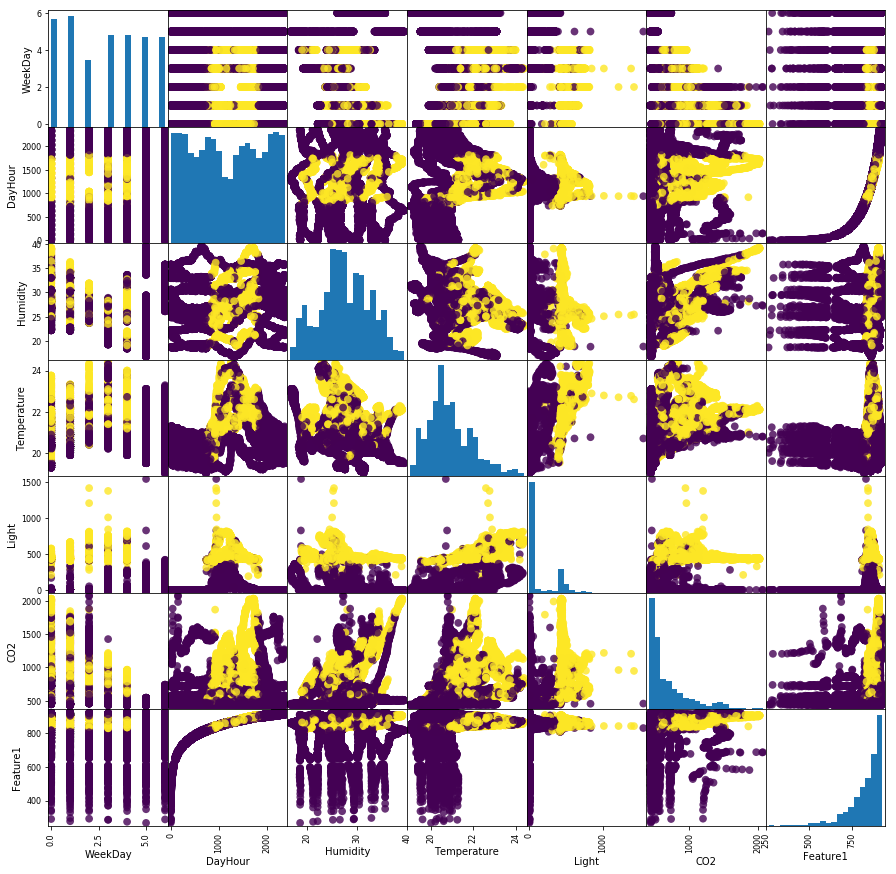

In [9]:
train_scatter_matrix = pd.plotting.scatter_matrix(train_X, c=train_y, figsize=(15, 15), marker='o', hist_kwds={'bins': 20}, s=60, alpha=.8)

## Some Custom Functions For Code Cleaning

The next three cells contain some methods which I wrote for keeping the code more neat and clean. They are useful for basicly virtualization of results, templating the output of results and grid search methods.

Their use cases are:
* **train_test_sonuc:** For training and testing our model for the same datasets and store the results in **sonuclar** list
* **plot_confusion_matrix:** For plotting confusion matrixes$^{[1]}$
* **plot_roc_curve:** For plotting Receiver Operating Characteristic curves$^{[2]}$
* **plot_precision_recall_curve:** For plotting Precision-Recall curves$^{[2]}$
* **bilgileri_cikar:** For giving our results in a tidy formation by using functions above
* **ortalama:** For getting the arithmetic mean of the given list
* **sonuclari_isle:** For getting the results of grid searches


***
**[1]** This function is an altered version of the function on this site: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

**[2]** This function is an altered version of a function on this site: https://www.kaggle.com/chirag19/fraud-detection-balancing-roc-pr-curves

In [10]:
def train_test_sonuc(model):
    model.fit(train_X, train_y)
    train_score = model.score(train_X, train_y)
    test_score = model.score(test_X, test_y)
    test2_score = model.score(test2_X, test2_y)
    sonuclar.append([train_score, test_score, test2_score])

def plot_confusion_matrix(ax, cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fmt = '.2f'
    tick_marks = np.arange(len(classes))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=90, va="center")
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [11]:
def plot_roc_curve(ax, y, y_pred, title="ROC Curve"):
    fpr, tpr, thresholds_roc = roc_curve(y, y_pred)
    roc_auc = auc(fpr,tpr)
    ax.plot(fpr,tpr, label = "AUC = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
    ax.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc = 'best')
    close_default = np.argmin(np.abs(thresholds_roc - 0.5))
    ax.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)

def plot_presicion_recall_curve(ax, y, y_pred_proba, title="Precision-Recall Curve"):
    precision, recall, thresholds_pr = precision_recall_curve(y, y_pred_proba)
    avg_pre = average_precision_score(y, y_pred_proba)
    area = auc(recall, precision)
    ax.plot(recall, precision, label = "Average precision = {:0.2f}, AUC = {:0.2f}".format(avg_pre, area), lw = 3, alpha = 0.7)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc = 'best')
    # plot no skill
    ax.plot([0, 1], [0.5, 0.5], linestyle='--')
    #find default threshold
    close_default = np.argmin(np.abs(thresholds_pr - 0.5))
    ax.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

In [12]:
def bilgileri_cikar(model, model_title):
    test_pred = model.predict(test_X)
    test_pred_proba = model.predict_proba(test_X)[:,1]
    test2_pred = model.predict(test2_X)
    test2_pred_proba = model.predict_proba(test2_X)[:,1]
    
    train_score = model.score(train_X, train_y)
    test_score = model.score(test_X, test_y)
    test2_score = model.score(test2_X, test2_y)
    
    classes = ["Not Occupied", "Occupied"]
    sinir = "\n" + "-"*50
    
    print("="*6, "Skorlar", "="*6)
    print("Training Score:\t{:.4f}".format(train_score))
    print("Test Score:\t\t{:.4f}".format(test_score))
    print("Test-2 Score:\t\t{:.4f}".format(test2_score))
    np.set_printoptions(precision=2)
    
    print(sinir)
    print("="*6, "Test Sınıflandırma Raporu", "="*6)
    print(classification_report(test_y, test_pred))
    cnf_matrix1 = confusion_matrix(test_y, test_pred)
    cnf_matrix1_nrm = cnf_matrix1.astype('float') / cnf_matrix1.sum(axis=1)[:, np.newaxis]
    print(sinir)
    
    print(sinir)
    print("="*6, "Test-2 Sınıflandırma Raporu", "="*6)
    print(classification_report(test2_y, test2_pred))
    cnf_matrix2 = confusion_matrix(test2_y, test2_pred)
    cnf_matrix2_nrm = cnf_matrix2.astype('float') / cnf_matrix2.sum(axis=1)[:, np.newaxis]
    print(sinir)
    
    fig, ax = plt.subplots(2, 3, figsize=(15, 10)) 
    fig.suptitle(model_title, fontsize=20)
    plot_confusion_matrix(ax[0, 0], cnf_matrix1_nrm, classes, title='Test Confusion Matrix')
    plot_roc_curve(ax[0,1], test_y, test_pred_proba, title="Test ROC Curve")
    plot_presicion_recall_curve(ax[0,2], test_y, test_pred_proba, title="Test Precision-Recall Curve")
    
    plot_confusion_matrix(ax[1, 0], cnf_matrix2_nrm, classes, title='Test-2 Confusion Matrix')
    plot_roc_curve(ax[1,1], test2_y, test2_pred_proba, title="Test-2 ROC Curve")
    plot_presicion_recall_curve(ax[1,2], test2_y, test2_pred_proba, title="Test-2 Precision-Recall Curve")
    sonuclar = {}
    sonuclar["Algoritma Adı"] = model_title
    sonuclar["Features"] = ",".join(secilen_sutunlar)
    sonuclar["Training Score"] = train_score
    sonuclar["Test Score"] = test_score
    sonuclar["Test-2 Score"] = test2_score
    test_precision_recall = {}
    test_precision_recall["Occupied Precision"] = precision_hesapla(cnf_matrix1[1,1], cnf_matrix1[1,0])
    test_precision_recall["Occupied Recall"] = recall_hesapla(cnf_matrix1[1,1], cnf_matrix1[0,1])
    test_precision_recall["Not-Occupied Precision"] = precision_hesapla(cnf_matrix1[0,0], cnf_matrix1[0,1])
    test_precision_recall["Not-Occupied Recall"] = recall_hesapla(cnf_matrix1[0,0], cnf_matrix1[1,0])
    #sonuclar["Test Precision-Recall"] = test_precision_recall
    test2_precision_recall = {}
    test2_precision_recall["Occupied Precision"] = precision_hesapla(cnf_matrix2[1,1], cnf_matrix2[1,0])
    test2_precision_recall["Occupied Recall"] = recall_hesapla(cnf_matrix2[1,1], cnf_matrix2[0,1])
    test2_precision_recall["Not-Occupied Precision"] = precision_hesapla(cnf_matrix2[0,0], cnf_matrix2[0,1])
    test2_precision_recall["Not-Occupied Recall"] = recall_hesapla(cnf_matrix2[0,0], cnf_matrix2[1,0])
    #sonuclar["Test-2 Precision-Recall"] = test2_precision_recall
    tum_degerler.append(sonuclar)

def precision_hesapla(TP, FP):
    return TP/(TP + FP)

def recall_hesapla(TP, FN):
    return TP/(TP + FN)
    
def ortalama(x):
    return (x[1]+x[2])/2

def sonuclari_isle(degerler):
    en_iyi_deger = 0
    print("Değer\tTraining Score\tTest Score\tTest-2 Score")
    for i, x in enumerate(sonuclar):
        print("{}:\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(degerler[i], x[0], x[1], x[2]))
        if x[1] > sonuclar[en_iyi_deger][1]:
            en_iyi_deger = i
    print("="*20, "\n")
    return degerler[en_iyi_deger]

# Gaussian Naive Bayes

For naive bayes algorithm, I choose GaussianNB because it works much better for numerical values than BernoulliNB and MultinomialNB. Unfortunately, only tuning for naive bayes will be preprocessing the data. So, there will be no hyperparameter tuning for naive bayes as do I in the other algorithms.

The given results indicates it worked pretty well with no preprocessing of data, and by looking at the ROC curve area under the curve(AUC) it predicts the true labels good, but also when we look at the PRC(Precision-Recall Curve) it also makes good predictions based on the average precision and AUC...

Overall, by looking at the classification report, it doesn't work perfect, but it predicts good...

Gaussian Naive Bayes
====== Skorlar ======
Training Score:	0.9645
Test Score:		0.9655
Test-2 Score:		0.9622

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.96      0.98      4754
          1       0.87      1.00      0.93      1414

avg / total       0.97      0.97      0.97      6168


--------------------------------------------------

--------------------------------------------------
====== Test-2 Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.95      0.98      7703
          1       0.85      1.00      0.92      2049

avg / total       0.97      0.96      0.96      9752


--------------------------------------------------


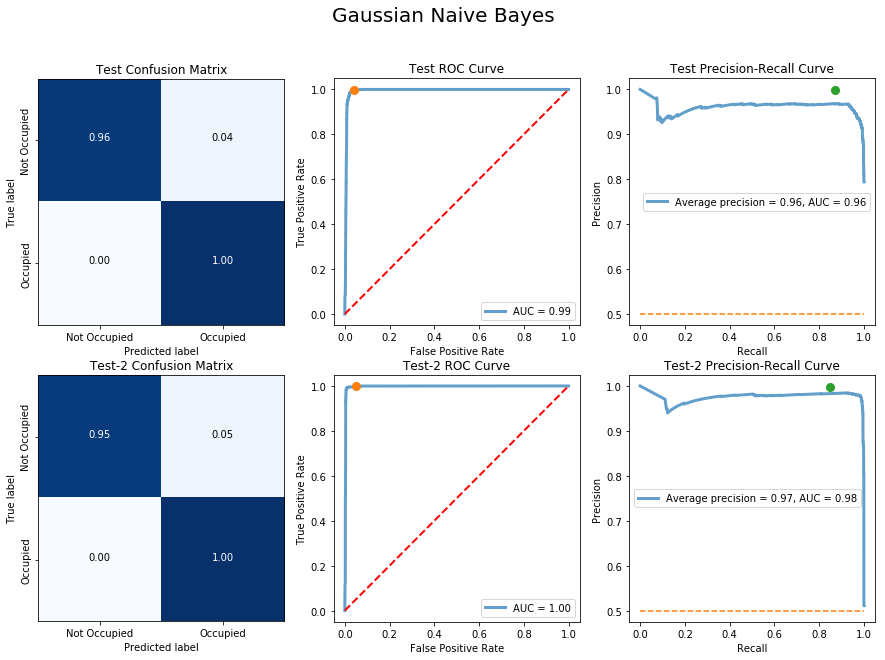

In [13]:
model_title = "Gaussian Naive Bayes"
print(model_title)
gnb = GaussianNB()
gnb.fit(train_X, train_y)

bilgileri_cikar(gnb, model_title)

# Decision Tree

For decision tree classifier algorithm, I grid searched for the optimum value of max_leaf_nodes parameter, which describes the number of maximum leaf nodes a tree can have. As the leaf node numbers increase, the algorithm will be tending to be overfit. So, I give some values to this parameter and draw a graphic to find the sweet point and by looking at the graphic, I choose this point to be **50**.

**I have done it because, it may have better test2 results on the continuum, but, as I have told earlier, we musn't forget that we combine our data and then split it into two, which means our training data may contain a lot of information from test2, but not from test data. So, our priority will be test results, not the test2 results for all the algorithms we use...**

As we look at the scores and the ROC and PRC curves, the results are very impressive. The algorithm learns the data very well, and generalizes it as well. This can be said by looking at **0.99** ROC AUC and **0.98** Average Precision.(Again test scores)

Değer	Training Score	Test Score	Test-2 Score
5:		0.9902		0.9903		0.9937
10:		0.9912		0.9898		0.9935
15:		0.9938		0.9916		0.9949
25:		0.9951		0.9921		0.9958
50:		0.9971		0.9930		0.9965
100:		0.9997		0.9929		0.9985
150:		1.0000		0.9919		0.9985
200:		1.0000		0.9919		0.9985
250:		1.0000		0.9919		0.9985



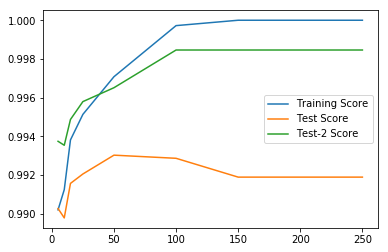

In [14]:
leaf_nums = [5, 10, 15, 25, 50, 100, 150, 200, 250]
sonuclar = []
for x in leaf_nums:
    dt = DecisionTreeClassifier(max_leaf_nodes=x, random_state=1)
    train_test_sonuc(dt)

n = sonuclari_isle(leaf_nums)
plt.plot(leaf_nums, sonuclar)
plt.legend(sonuc_legend)

Decision Tree max_leaf_nodes: 50
====== Skorlar ======
Training Score:	0.9971
Test Score:		0.9930
Test-2 Score:		0.9965

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      4754
          1       0.98      0.99      0.98      1414

avg / total       0.99      0.99      0.99      6168


--------------------------------------------------

--------------------------------------------------
====== Test-2 Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7703
          1       0.99      1.00      0.99      2049

avg / total       1.00      1.00      1.00      9752


--------------------------------------------------


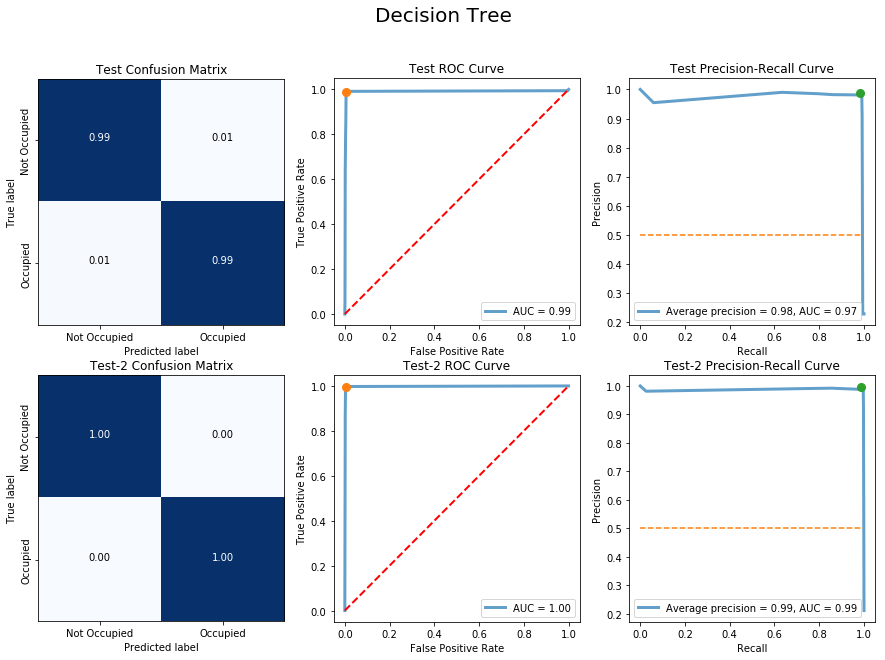

In [15]:
model_title = "Decision Tree"
print(model_title, "max_leaf_nodes:", n)
dt = DecisionTreeClassifier(max_leaf_nodes=n, random_state=1)
dt.fit(train_X, train_y)

bilgileri_cikar(dt, model_title)

# Random Forest 

Random Forest algorithm is basicly a forest of decision trees, It evaluates the data with a forest of trees and then gives the best result. It also have much more tendency to be overfit. So, we must be very careful when we use it.

As we do all of the algorithms in this project, we start by grid searching for max_leaf_nodes parameter's optimal value. As the decision tree's max_leaf_nodes parameter, this parameter determines the maximum leaf number of each tree in the forest, and like that, as this value increases, the algorithm will have more tendency to be overfit.

As the result of the grid search our max_leaf_nodes value is **100**, for this value gives us the sweet point. And when we look at the confusion matrixes and the ROC and PRC curves, model doesn't look like overfitted or underfitted. 

Değer	Training Score	Test Score	Test-2 Score
5:		0.9900		0.9903		0.9944
10:		0.9901		0.9904		0.9944
15:		0.9916		0.9908		0.9944
25:		0.9934		0.9917		0.9944
50:		0.9968		0.9935		0.9960
100:		0.9992		0.9946		0.9986
150:		0.9997		0.9946		0.9990
200:		0.9997		0.9946		0.9990
250:		0.9997		0.9946		0.9990



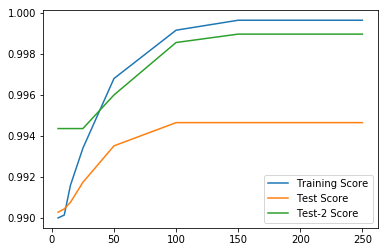

In [16]:
leaf_nums = [5, 10, 15, 25, 50, 100, 150, 200, 250]
sonuclar = []
for x in leaf_nums:
    rf = RandomForestClassifier(max_leaf_nodes=x, random_state=1)
    train_test_sonuc(rf)

n = sonuclari_isle(leaf_nums)
plt.plot(leaf_nums, sonuclar)
plt.legend(sonuc_legend)

RandomForest max_leaf_nodes: 100
====== Skorlar ======
Training Score:	0.9992
Test Score:		0.9946
Test-2 Score:		0.9986

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4754
          1       0.99      0.99      0.99      1414

avg / total       0.99      0.99      0.99      6168


--------------------------------------------------

--------------------------------------------------
====== Test-2 Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7703
          1       1.00      1.00      1.00      2049

avg / total       1.00      1.00      1.00      9752


--------------------------------------------------


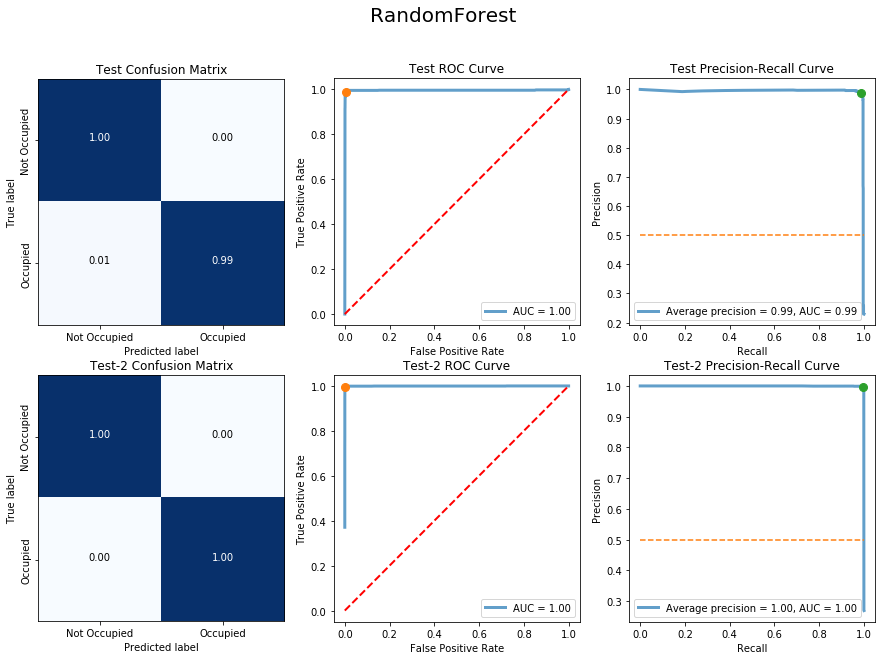

In [17]:
model_title = "RandomForest"
print(model_title, "max_leaf_nodes:", n)
rf = RandomForestClassifier(max_leaf_nodes=n,random_state=1)
rf.fit(train_X, train_y)

bilgileri_cikar(rf, model_title)

# Gradient Boosting Machine

After another tree based algorithm and another max_leaf_nodes parameter tuning, this time the optimal value calculated as **15** which hits our sweet point. But this algorithm has some strange outcomes which is although the ROC AUC is **1.00** with average precision and AUC of PRC **0.99** there is one time drop on the PRC curve, I don't know what caused this, but when I searched online I found the cause of the problem.$^{[3]}$

These are the definitions of precision and recall:
<img src="PRC.png">

which TP means True Positives, FP means False Positives and of course FN means False Negatives...

Suppose, after sorting the true labels by the corresponding classifier scores, we obtain the following:

* {False,True,False,True,True,True,False,False}

which leads to following values in precision and recall:
* Precision: {0, 0.5, 0.33, 0.5, 0.6, 0.66, 0.57, 0.5}
* Recall: {0, 0.25, 0.25, 0.5, 0.75, 1, 1, 1}

As we can see, although the recall value increases monotonically, precision values doesn't have to... So it's all about our treshold values, and this is normal...

***

Also, in sklearn, we can use partial dependency graphs only for Gradient Boosting Machines, so I've used them to identify which features on our model is more dependent. As we can see from the graphich, when the light increases, there is more probability to be a human in the room, but the other features doesn't explicitly impose this kind of information. But that doesn't mean they are useless, this graphs only gives us information about one feature and occupancy at a time. They can produce much more valuable information together...
***
***
**[3]** https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

Değer	Training Score	Test Score	Test-2 Score
5:		0.9947		0.9929		0.9954
10:		0.9975		0.9927		0.9971
15:		0.9976		0.9934		0.9973
25:		0.9980		0.9932		0.9976
50:		0.9980		0.9932		0.9976
100:		0.9980		0.9932		0.9976



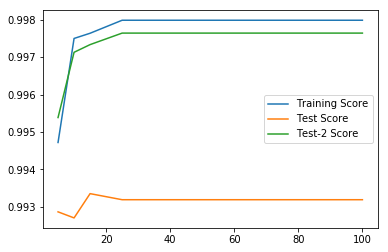

In [18]:
leaf_nums = [5, 10, 15, 25, 50, 100]
sonuclar = []
for x in leaf_nums:
    gb = GradientBoostingClassifier(max_leaf_nodes=x, random_state=1)
    train_test_sonuc(gb)

n = sonuclari_isle(leaf_nums)
plt.plot(leaf_nums, sonuclar)
plt.legend(sonuc_legend)

GradientBoostingMachine max_leaf_nodes: 15
====== Skorlar ======
Training Score:	0.9976
Test Score:		0.9934
Test-2 Score:		0.9973

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      4754
          1       0.98      0.99      0.99      1414

avg / total       0.99      0.99      0.99      6168


--------------------------------------------------

--------------------------------------------------
====== Test-2 Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7703
          1       0.99      1.00      0.99      2049

avg / total       1.00      1.00      1.00      9752


--------------------------------------------------


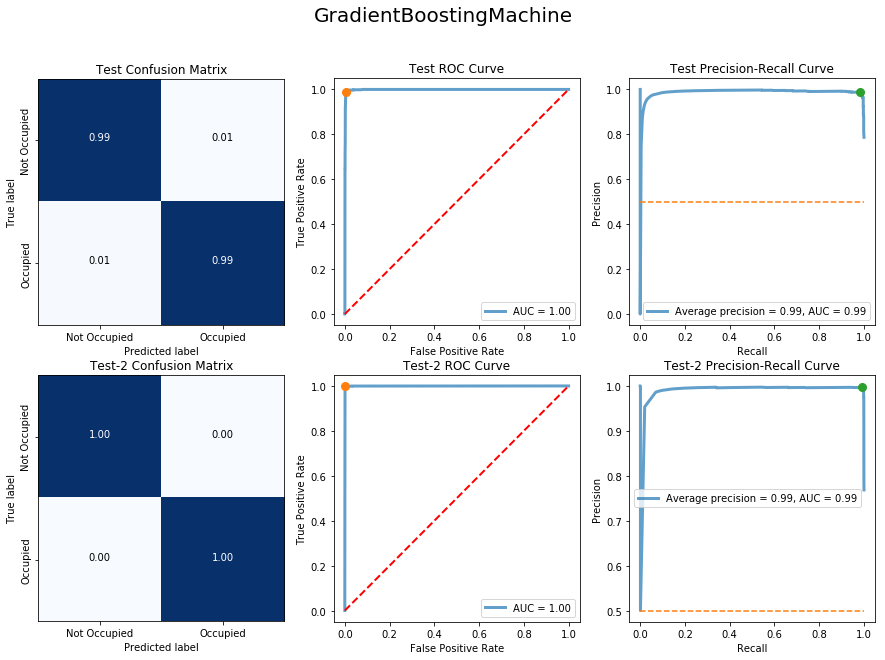

In [19]:
model_title = "GradientBoostingMachine"
print(model_title, "max_leaf_nodes:", n)
gb = GradientBoostingClassifier(max_leaf_nodes=n, random_state=1)
gb.fit(train_X, train_y)

bilgileri_cikar(gb, model_title)

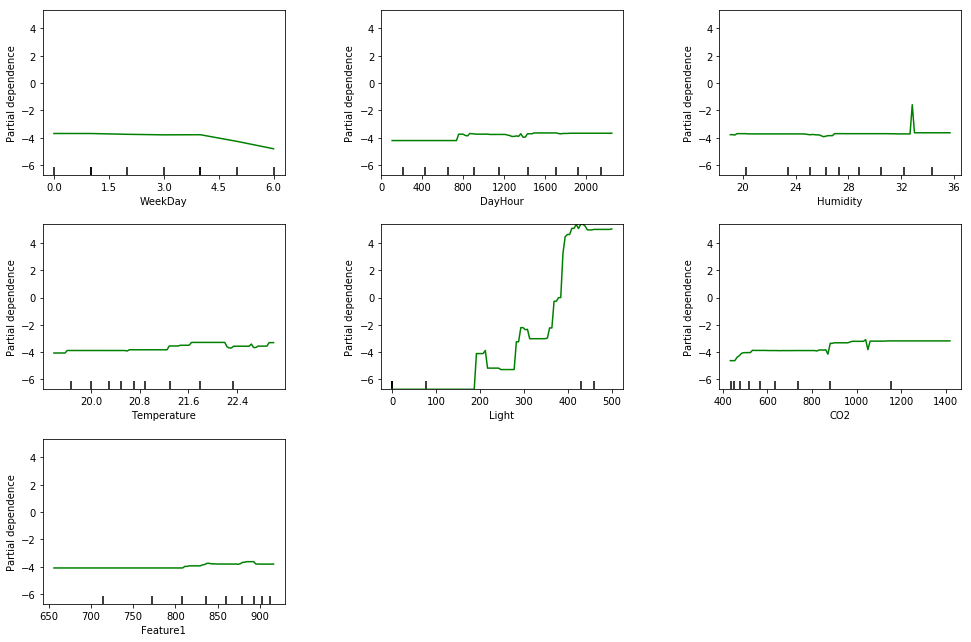

In [20]:
partial_dependences = plot_partial_dependence(gb, 
                                                                               features=range(0, len(secilen_sutunlar)),
                                                                               X=train_X,
                                                                               feature_names=secilen_sutunlar, 
                                                                               grid_resolution=100,
                                                                               figsize=(15, 15))

# ADABoostClassifier

In [21]:
parameters = [
    [50, 0.0001],
    [50, 0.001],
    [50, 0.01],
    [50, 0.1],
    [50, 0.5],
    [50, 1],
    [50, 10],
    [100, 0.0001],
    [100, 0.001],
    [100, 0.01],
    [100, 0.1],
    [100, 0.5],
    [100, 1],
    [100, 10],
    ]
sonuclar = []
for x in parameters:
    print("Denenen Parametreler:", x)
    ada = AdaBoostClassifier(n_estimators=x[0], learning_rate=x[1], random_state=1)
    train_test_sonuc(ada)

n = sonuclari_isle(parameters)
print(n)

Denenen Parametreler: [50, 0.0001]
Denenen Parametreler: [50, 0.001]
Denenen Parametreler: [50, 0.01]
Denenen Parametreler: [50, 0.1]
Denenen Parametreler: [50, 0.5]
Denenen Parametreler: [50, 1]
Denenen Parametreler: [50, 10]
Denenen Parametreler: [100, 0.0001]
Denenen Parametreler: [100, 0.001]
Denenen Parametreler: [100, 0.01]
Denenen Parametreler: [100, 0.1]
Denenen Parametreler: [100, 0.5]
Denenen Parametreler: [100, 1]
Denenen Parametreler: [100, 10]
Değer	Training Score	Test Score	Test-2 Score
[50, 0.0001]:		0.9889		0.9904		0.9937
[50, 0.001]:		0.9889		0.9904		0.9937
[50, 0.01]:		0.9889		0.9904		0.9937
[50, 0.1]:		0.9894		0.9909		0.9944
[50, 0.5]:		0.9899		0.9909		0.9944
[50, 1]:		0.9908		0.9906		0.9938
[50, 10]:		0.0113		0.0096		0.0066
[100, 0.0001]:		0.9889		0.9904		0.9937
[100, 0.001]:		0.9889		0.9904		0.9937
[100, 0.01]:		0.9889		0.9904		0.9937
[100, 0.1]:		0.9899		0.9909		0.9944
[100, 0.5]:		0.9915		0.9914		0.9945
[100, 1]:		0.9919		0.9912		0.9943
[100, 10]:		0.0113		0.0096

ADABoostClassifier parametreler: [100, 0.5]
====== Skorlar ======
Training Score:	0.9915
Test Score:		0.9914
Test-2 Score:		0.9945

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      4754
          1       0.97      0.99      0.98      1414

avg / total       0.99      0.99      0.99      6168


--------------------------------------------------

--------------------------------------------------
====== Test-2 Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      7703
          1       0.98      1.00      0.99      2049

avg / total       0.99      0.99      0.99      9752


--------------------------------------------------


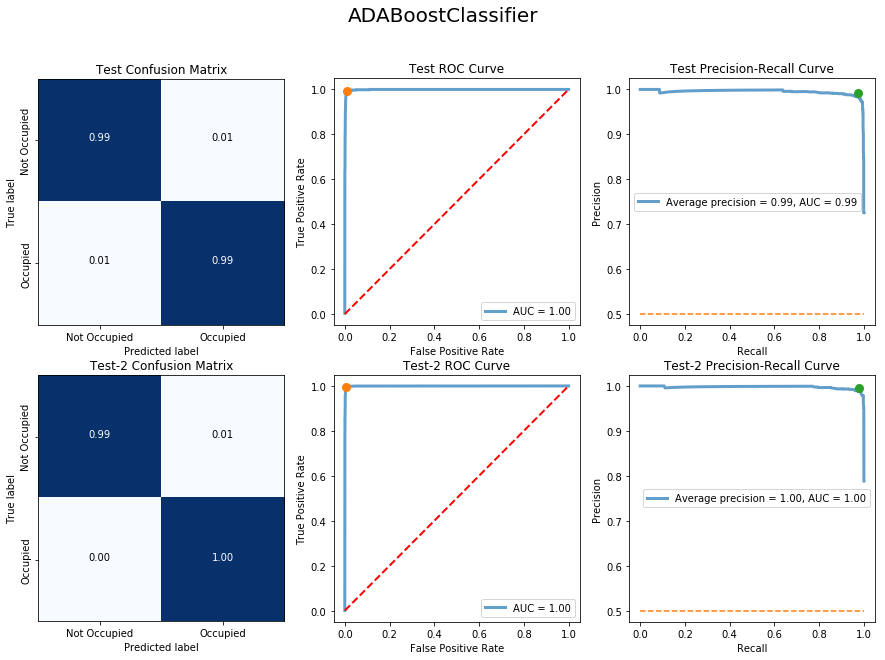

In [22]:
n = [100, 0.5]
model_title = "ADABoostClassifier"
print(model_title, "parametreler:", n)
ada = AdaBoostClassifier(n_estimators=n[0], learning_rate=n[1], random_state=1)
ada.fit(train_X, train_y)

bilgileri_cikar(ada, model_title)

# Scaling

We are going to use algorithms based on proportional distances between the data points in space, so if we give our data to these algorithms without normalizing our data, it can have too much distances between points in space. For example, when we have two features and one feature does scale between **1000 - 100000** but the other changes between **0-1**. This can make our model to be sensitive about this much scale change. We don't want this because it can eliminate important features to useful for our model. So we usually scale the data in this type of algorithms.

Some of the algorithms that needed scaling for example:

* k-Nearest Neighbors
* Support Vector Machines
* Logistic Regressions
* Neural Networks
* ...

There are several type of scaling methods like **MinMaxScaler, StandardScaler, RobustScaler**, and we will use MinMaxScaler for SVM, LogisticRegression and kNN, and the StandartScaler for Neural Network. That is, because these algorithms work differently and the best results came from these combinations. MinMaxScaler gets the maximum and minimum values and gives them the values of 0 and 1 and the values between these minimum and maximum values transforms into values between 0 and 1 as respect to ratio between them. But the StandardScaler does different type of work on data, which makes our data's mean close to 0 and variant close to 1. And the Neural Network algorithms are good with this type of data.

**Note:** Although not every time scaling our data give us good results, it usually does.

In [23]:
train_X_without_scale = train_X.copy()
test_X_without_scale = test_X.copy()
test2_X_without_scale = test2_X.copy()

In [24]:
scaler = MinMaxScaler()

scaler.fit(train_X_without_scale)
train_X = scaler.transform(train_X_without_scale)
test_X = scaler.transform(test_X_without_scale)
test2_X = scaler.transform(test2_X_without_scale)

pd.DataFrame(train_X, columns=secilen_sutunlar).describe()

,WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1
count,14392.000000,14392.000000,14392.000000,14392.000000,14392.000000,14392.000000,14392.000000
mean,0.481541,0.498305,0.477777,0.354929,0.084689,0.167256,0.854919
std,0.341970,0.300523,0.218042,0.195750,0.136048,0.187252,0.142251
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.166667,0.229432,0.340398,0.222635,0.000000,0.028400,0.796701
50%,0.500000,0.487701,0.461635,0.315399,0.000000,0.092111,0.900790
75%,0.833333,0.770144,0.635245,0.471707,0.200474,0.235988,0.958959
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Logistic Regression

Değer	Training Score	Test Score	Test-2 Score
0.001:		0.7682		0.7708		0.7899
0.01:		0.9078		0.9084		0.9229
0.05:		0.9701		0.9669		0.9724
0.1:		0.9817		0.9818		0.9855
0.5:		0.9894		0.9912		0.9944
0.75:		0.9894		0.9912		0.9944
10:		0.9890		0.9909		0.9936



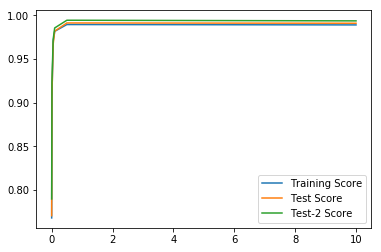

In [25]:
c_values = [0.001, 0.01, 0.05, 0.1, 0.5, 0.75, 10]
sonuclar = []
for x in c_values:
    lr = LogisticRegression(C=x, random_state=0)
    train_test_sonuc(lr)
    
c = sonuclari_isle(c_values)
plt.plot(c_values, sonuclar)
plt.legend(sonuc_legend)

LogisticRegression C: 0.5
====== Skorlar ======
Training Score:	0.9894
Test Score:		0.9912
Test-2 Score:		0.9944

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      4754
          1       0.97      1.00      0.98      1414

avg / total       0.99      0.99      0.99      6168


--------------------------------------------------

--------------------------------------------------
====== Test-2 Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      7703
          1       0.98      1.00      0.99      2049

avg / total       0.99      0.99      0.99      9752


--------------------------------------------------


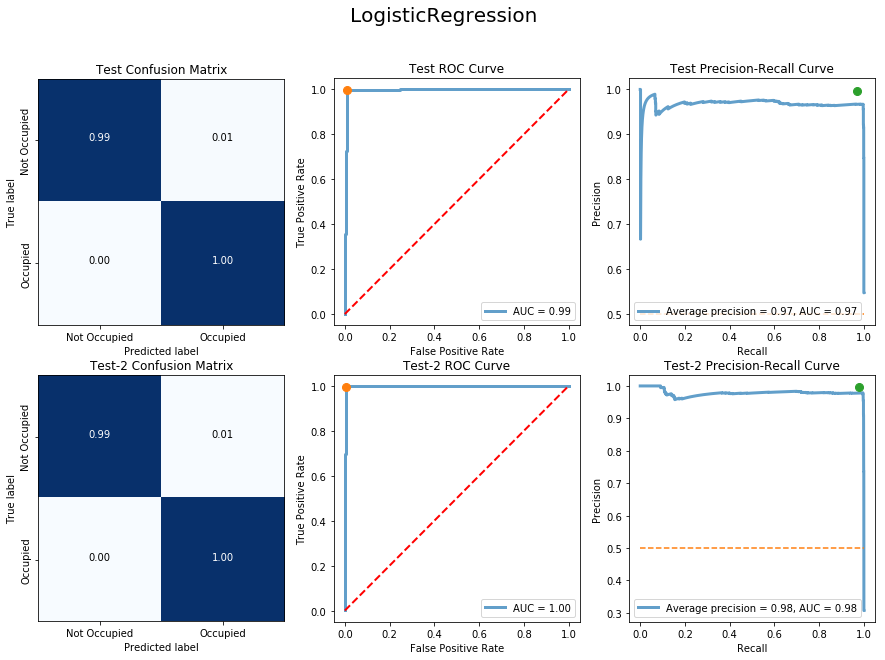

In [26]:
model_title = "LogisticRegression"
print(model_title, "C:", c)
lr = LogisticRegression(C=c, random_state=1)
lr.fit(train_X, train_y)

bilgileri_cikar(lr, model_title)

# k-Nearest Neighbors

Değer	Training Score	Test Score	Test-2 Score
1:		1.0000		0.9929		0.9986
3:		0.9967		0.9934		0.9965
5:		0.9946		0.9930		0.9954
10:		0.9930		0.9927		0.9953
25:		0.9911		0.9917		0.9934
50:		0.9887		0.9904		0.9936



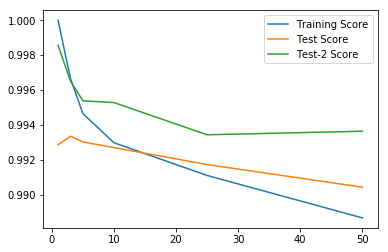

In [27]:
neighbor_nums = [1, 3, 5, 10, 25, 50]
sonuclar = []
for x in neighbor_nums:
    knn = KNeighborsClassifier(n_neighbors=x)
    train_test_sonuc(knn)

n = sonuclari_isle(neighbor_nums)
plt.plot(neighbor_nums, sonuclar)
plt.legend(sonuc_legend)

KNN n_neighbors: 3
====== Skorlar ======
Training Score:	0.9967
Test Score:		0.9934
Test-2 Score:		0.9965

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4754
          1       0.99      0.99      0.99      1414

avg / total       0.99      0.99      0.99      6168


--------------------------------------------------

--------------------------------------------------
====== Test-2 Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7703
          1       0.99      0.99      0.99      2049

avg / total       1.00      1.00      1.00      9752


--------------------------------------------------


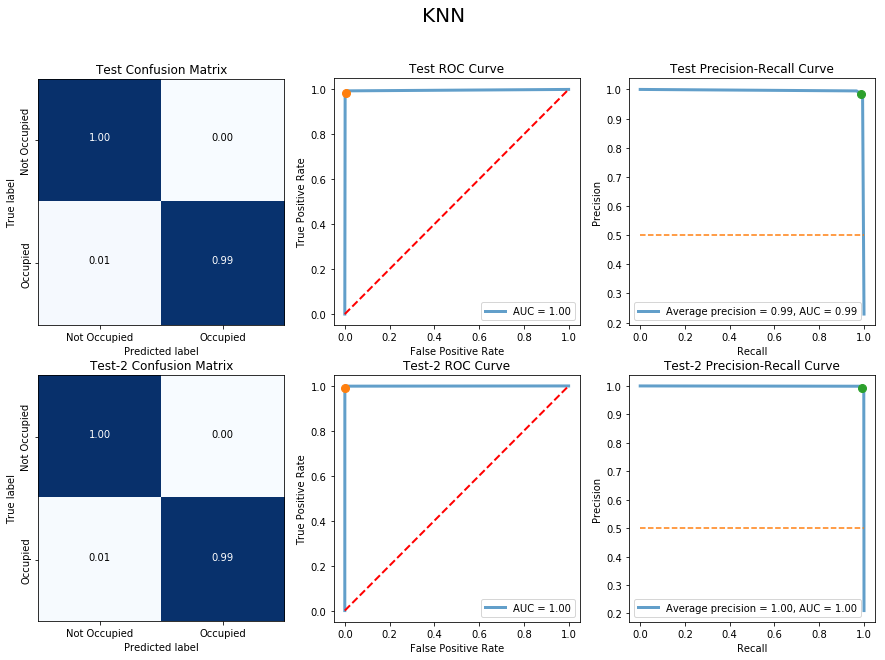

In [28]:
model_title = "KNN"
print(model_title, "n_neighbors:", n)
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(train_X, train_y)

bilgileri_cikar(knn, model_title)

# Support Vector Machine

In [29]:
parameters = [
    ["linear", 10, 0.001, "linear-g:10-C:0.001"],
    ["linear", 10, 0.01, "linear-g:10-C:0.001"],
    ["linear", 10, 0.05, "linear-g:10-C:0.001"],
    ["linear", 10, 0.1, "linear-g:10-C:0.001"],
    ["linear", 10, 0.5, "linear-g:10-C:0.001"],
    ["linear", 10, 0.75, "linear-g:10-C:0.001"],
    ["linear", 10, 1, "linear-g:10-C:0.001"],
    ["linear", 10, 10, "linear-g:10-C:0.001"],
    ["rbf", 10, 0.001, "linear-g:10-C:0.001"],
    ["rbf", 10, 0.01, "linear-g:10-C:0.001"],
    ["rbf", 10, 0.05, "linear-g:10-C:0.001"],
    ["rbf", 10, 0.1, "linear-g:10-C:0.001"],
    ["rbf", 10, 0.5, "linear-g:10-C:0.001"],
    ["rbf", 10, 0.75, "linear-g:10-C:0.001"],
    ["rbf", 10, 1, "linear-g:10-C:0.001"],
    ["rbf", 10, 10, "linear-g:10-C:0.001"],
    ["poly", 10, 0.001, "linear-g:10-C:0.001"],
    ["poly", 10, 0.01, "linear-g:10-C:0.001"],
    ["poly", 10, 0.05, "linear-g:10-C:0.001"],
    ["poly", 10, 0.1, "linear-g:10-C:0.001"],
    ["poly", 10, 0.5, "linear-g:10-C:0.001"],
    ["poly", 10, 0.75, "linear-g:10-C:0.001"],
    ["poly", 10, 1, "linear-g:10-C:0.001"],
    ["poly", 10, 10, "linear-g:10-C:0.001"],
]
sonuclar = []
for x in parameters:
    print("Denenen Parametreler:", x)
    svm = SVC(kernel=x[0], gamma=x[1], C=x[2], random_state=1)
    train_test_sonuc(svm)

print("\n\n")
n = sonuclari_isle(parameters)
print(n)
#plt.plot(parameters, sonuclar)
#plt.legend(sonuc_legend)

Denenen Parametreler: ['linear', 10, 0.001, 'linear-g:10-C:0.001']
Denenen Parametreler: ['linear', 10, 0.01, 'linear-g:10-C:0.001']
Denenen Parametreler: ['linear', 10, 0.05, 'linear-g:10-C:0.001']
Denenen Parametreler: ['linear', 10, 0.1, 'linear-g:10-C:0.001']
Denenen Parametreler: ['linear', 10, 0.5, 'linear-g:10-C:0.001']
Denenen Parametreler: ['linear', 10, 0.75, 'linear-g:10-C:0.001']
Denenen Parametreler: ['linear', 10, 1, 'linear-g:10-C:0.001']
Denenen Parametreler: ['linear', 10, 10, 'linear-g:10-C:0.001']
Denenen Parametreler: ['rbf', 10, 0.001, 'linear-g:10-C:0.001']
Denenen Parametreler: ['rbf', 10, 0.01, 'linear-g:10-C:0.001']
Denenen Parametreler: ['rbf', 10, 0.05, 'linear-g:10-C:0.001']
Denenen Parametreler: ['rbf', 10, 0.1, 'linear-g:10-C:0.001']
Denenen Parametreler: ['rbf', 10, 0.5, 'linear-g:10-C:0.001']
Denenen Parametreler: ['rbf', 10, 0.75, 'linear-g:10-C:0.001']
Denenen Parametreler: ['rbf', 10, 1, 'linear-g:10-C:0.001']
Denenen Parametreler: ['rbf', 10, 10, 'li

Kernelized Support Vector Machine parametreler: ['poly', 1, 10]
====== Skorlar ======
Training Score:	0.9897
Test Score:		0.9916
Test-2 Score:		0.9946

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      0.99      4754
          1       0.97      1.00      0.98      1414

avg / total       0.99      0.99      0.99      6168


--------------------------------------------------

--------------------------------------------------
====== Test-2 Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      7703
          1       0.98      1.00      0.99      2049

avg / total       0.99      0.99      0.99      9752


--------------------------------------------------


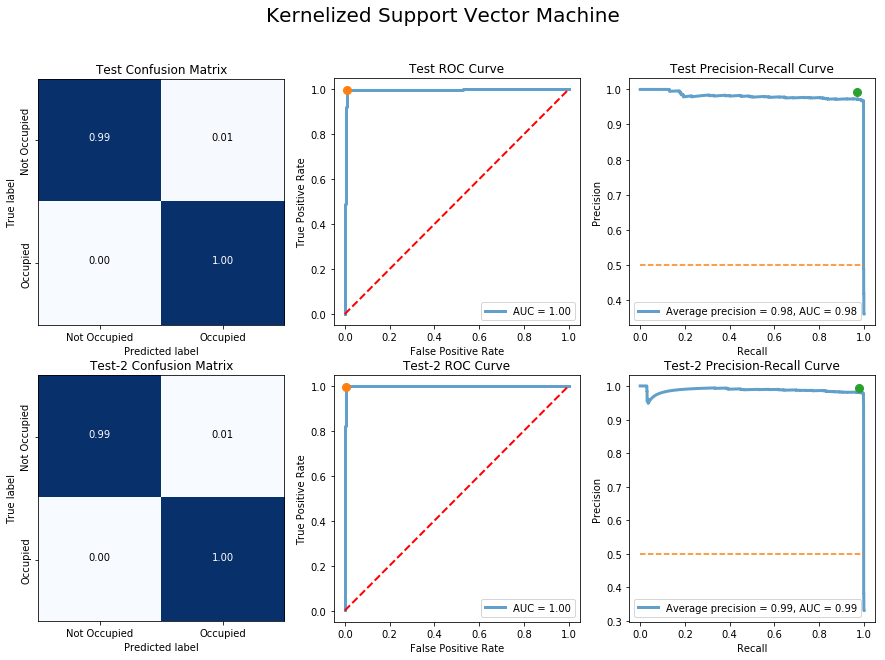

In [30]:
n = ['poly', 1, 10]
model_title = "Kernelized Support Vector Machine"
print(model_title, "parametreler:", n)
svm = SVC(kernel=n[0], gamma=n[1], C=n[2], random_state=1, probability=True)
svm.fit(train_X, train_y)

bilgileri_cikar(svm, model_title)

# Scaling For Neural Networks

In [31]:
scaler = StandardScaler()

scaler.fit(train_X_without_scale)
train_X = scaler.transform(train_X_without_scale)
test_X = scaler.transform(test_X_without_scale)
test2_X = scaler.transform(test2_X_without_scale)

pd.DataFrame(train_X, columns=secilen_sutunlar).describe()

,WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1
count,1.439200e+04,1.439200e+04,1.439200e+04,1.439200e+04,1.439200e+04,1.439200e+04,1.439200e+04
mean,-2.215509e-17,-6.672755e-17,4.929816e-16,3.897298e-15,2.669411e-16,-2.339630e-16,4.569102e-16
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,-1.408188e+00,-1.658187e+00,-2.191296e+00,-1.813238e+00,-6.225122e-01,-8.932463e-01,-6.010134e+00
25%,-9.207982e-01,-8.947175e-01,-6.300820e-01,-6.758566e-01,-6.225122e-01,-7.415754e-01,-4.092763e-01
50%,5.398133e-02,-3.528546e-02,-7.403516e-02,-2.019478e-01,-6.225122e-01,-4.013190e-01,3.224788e-01
75%,1.028761e+00,9.045860e-01,7.222178e-01,5.965885e-01,8.510905e-01,3.670667e-01,7.314057e-01
max,1.516151e+00,1.669466e+00,2.395145e+00,3.295499e+00,6.728072e+00,4.447335e+00,1.019929e+00


# Neural Network

In [32]:
parameters = [
    [0.01, [10]],
    [0.1, [10]],
    [0.5, [10]],
    [1, [10]],
    [10, [10]],
    [0.01, [100]],
    [0.1, [100]],
    [0.5, [100]],
    [1, [100]],
    [10, [100]],
    [0.01, [10, 10]],
    [0.1, [10, 10]],
    [0.5, [10, 10]],
    [1, [10, 10]],
    [10, [10, 10]],
    [0.01, [100, 100]],
    [0.1, [100, 100]],
    [0.5, [100, 100]],
    [1, [100, 100]],
    [10, [100, 100]],
    [0.01, [10, 10, 10]],
    [0.1, [10, 10, 10]],
    [0.5, [10, 10, 10]],
    [1, [10, 10, 10]],
    [10, [10, 10, 10]],
    [0.01, [100, 100, 100]],
    [0.1, [100, 100, 100]],
    [0.5, [100, 100, 100]],
    [1, [100, 100, 100]],
    [10, [100, 100, 100]],
]
sonuclar = []
for x in parameters:
    print("Test Parametresi:", x)
    mlp = MLPClassifier(alpha=x[0], hidden_layer_sizes=x[1], random_state=1)
    train_test_sonuc(mlp)

print("\n\n")
n = sonuclari_isle(parameters)
print(n)

Test Parametresi: [0.01, [10]]
Test Parametresi: [0.1, [10]]
Test Parametresi: [0.5, [10]]
Test Parametresi: [1, [10]]
Test Parametresi: [10, [10]]
Test Parametresi: [0.01, [100]]
Test Parametresi: [0.1, [100]]
Test Parametresi: [0.5, [100]]
Test Parametresi: [1, [100]]
Test Parametresi: [10, [100]]
Test Parametresi: [0.01, [10, 10]]
Test Parametresi: [0.1, [10, 10]]
Test Parametresi: [0.5, [10, 10]]
Test Parametresi: [1, [10, 10]]
Test Parametresi: [10, [10, 10]]
Test Parametresi: [0.01, [100, 100]]
Test Parametresi: [0.1, [100, 100]]
Test Parametresi: [0.5, [100, 100]]
Test Parametresi: [1, [100, 100]]
Test Parametresi: [10, [100, 100]]
Test Parametresi: [0.01, [10, 10, 10]]
Test Parametresi: [0.1, [10, 10, 10]]
Test Parametresi: [0.5, [10, 10, 10]]
Test Parametresi: [1, [10, 10, 10]]
Test Parametresi: [10, [10, 10, 10]]
Test Parametresi: [0.01, [100, 100, 100]]
Test Parametresi: [0.1, [100, 100, 100]]
Test Parametresi: [0.5, [100, 100, 100]]
Test Parametresi: [1, [100, 100, 100]]
Te

Neural Network parametreler: [0.01, [100, 100]]
====== Skorlar ======
Training Score:	0.9915
Test Score:		0.9927
Test-2 Score:		0.9945

--------------------------------------------------
====== Test Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      4754
          1       0.97      1.00      0.98      1414

avg / total       0.99      0.99      0.99      6168


--------------------------------------------------

--------------------------------------------------
====== Test-2 Sınıflandırma Raporu ======
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      7703
          1       0.98      1.00      0.99      2049

avg / total       0.99      0.99      0.99      9752


--------------------------------------------------


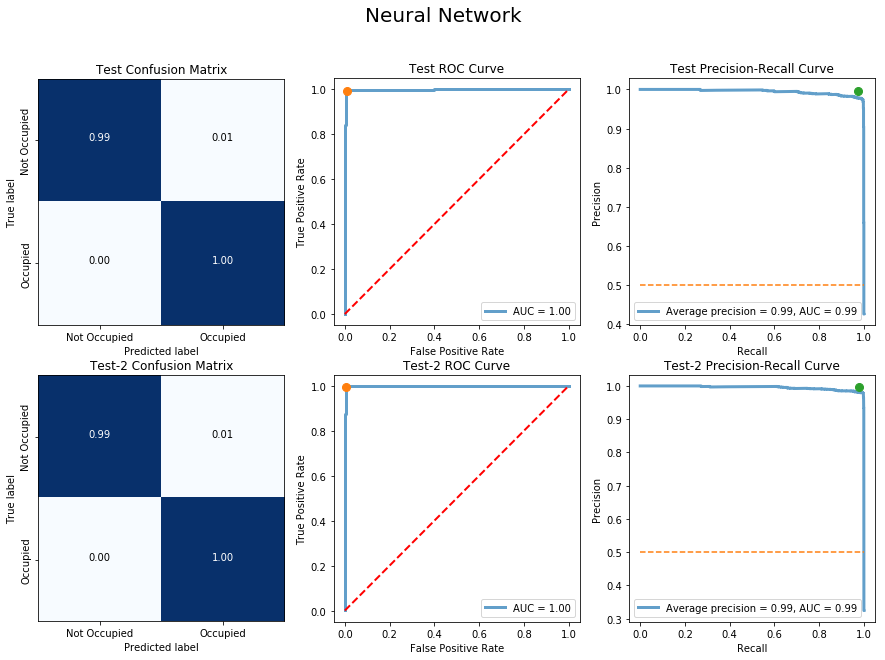

In [33]:
n = [0.01, [100, 100]]
model_title = "Neural Network"
print(model_title, "parametreler:", n)
mlp = MLPClassifier(alpha=n[0], hidden_layer_sizes=n[1], random_state=1)
mlp.fit(train_X, train_y)

bilgileri_cikar(mlp, model_title)

# Feature Importances

For tree based algorithms we can see which feature has more weight on the result. As one of the project's purposes, we will examine the feature importances for tree based algorithms. Which are;

* Decision Tree Classifier
* Random Forest Classifier
* Gradient Boosting Classifier
* and ADABoost Classifier

I have decided visualizing the importances, rather than giving it as text results, and used subplots to have a neat output.

In Decision Tree the Light feature has almost %100 importance and our newly created Feature1 has some too, but the others have %0 impact on the result. This is not wanted, so we could put more weights on some of the features, but this is mainly discouraged to do. As the machine learning algorithms are giving importance on features based on statistical calculations.

And for the other algorithms, our newly created features have much more impact on the results, sometimes even more than the original features themselfs.

Text(0.5,1,'ADABoost Importance Results')

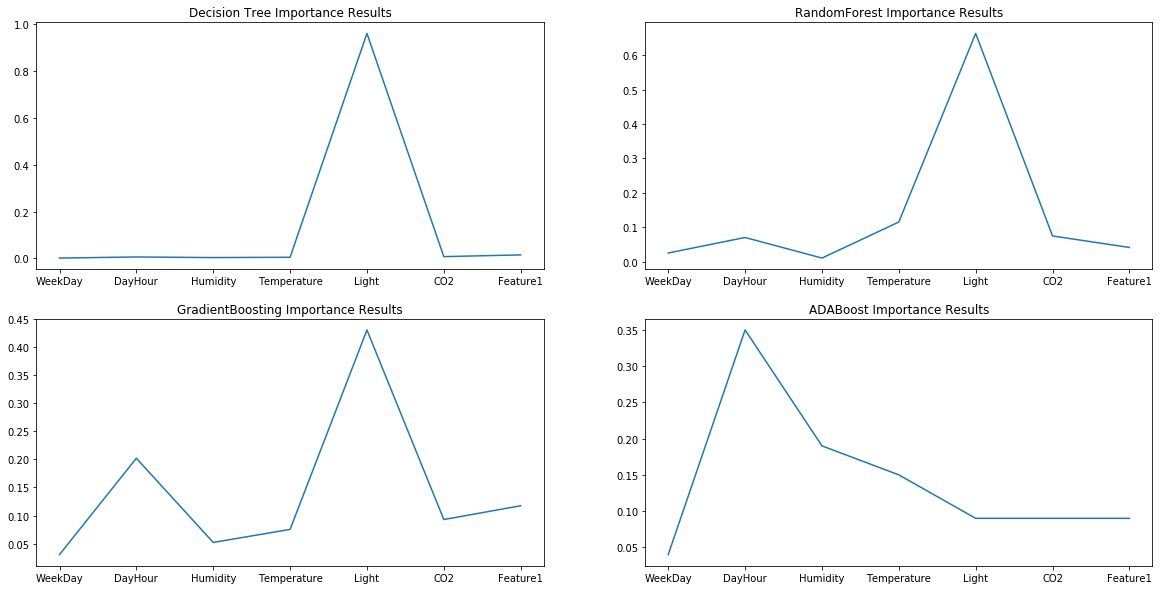

In [34]:
dt_feature_importances = dt.feature_importances_
rf_feature_importances = rf.feature_importances_
gb_feature_importances = gb.feature_importances_
ada_feature_importances = ada.feature_importances_

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0, 0].plot(secilen_sutunlar, dt_feature_importances)
ax[0, 0].set_title("Decision Tree Importance Results")
ax[0, 1].plot(secilen_sutunlar, rf_feature_importances)
ax[0, 1].set_title("RandomForest Importance Results")
ax[1, 0].plot(secilen_sutunlar, gb_feature_importances)
ax[1, 0].set_title("GradientBoosting Importance Results")
ax[1, 1].plot(secilen_sutunlar, ada_feature_importances)
ax[1, 1].set_title("ADABoost Importance Results")

## Decision Tree and Results Matrix Export

As an extra, I exported the decision tree to a PNG file...

<img src="dt.png">

And also exported the tum_degerler matrix to a csv files for different combinations of features. And then combine them into one dataframe to show results as whole...

In [35]:
from sklearn.tree import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

export_graphviz(dt,
                         out_file=decision_tree_dosya_adi + ".dot",
                         feature_names=secilen_sutunlar,  
                         class_names=["Not Occupied", "Occupied"],  
                         filled=True, rounded=True,  
                         special_characters=True)

In [36]:
tum_degerler_df = pd.DataFrame(tum_degerler)
pd.options.display.max_colwidth = 500

display(tum_degerler_df)
tum_degerler_df.to_csv(tum_degerler_dosya_adi + ".csv",index=False)

,Algoritma Adı,Features,Test Score,Test-2 Score,Training Score
0,Gaussian Naive Bayes,"WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1",0.965467,0.962162,0.964494
1,Decision Tree,"WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1",0.993029,0.996514,0.997082
2,RandomForest,"WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1",0.994650,0.998564,0.999166
3,GradientBoostingMachine,"WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1",0.993353,0.997334,0.997638
4,ADABoostClassifier,"WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1",0.991407,0.994463,0.991454
5,LogisticRegression,"WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1",0.991245,0.994360,0.989439
6,KNN,"WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1",0.993353,0.996514,0.996665
7,Kernelized Support Vector Machine,"WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1",0.991569,0.994565,0.989717
8,Neural Network,"WeekDay,DayHour,Humidity,Temperature,Light,CO2,Feature1",0.992704,0.994463,0.991523


# Conclusion

I've tried these algorithms with different combinations of features and different combinations of parameters. The algorithms that have taken the most runtime on grid search step are **SVC and Neural Networks** as expected, for their parameter count and complexities are higher than the others.

The best model for this experiment is **kNN with Temperature,Light,CO2,WeekDay,DayHour features** which has **0.9987** Test Score and **1.00** Test-2 Score...

In [37]:
from glob import glob

allFiles = glob("*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None)
    list_.append(df)
frame = pd.concat(list_)
frame = frame.reset_index(drop=1)

frame.columns = ["Algoritma Adı", "Features", "Training Score", "Test Score", "Test-2 Score"]
pd.options.display.max_rows = None

display(frame)

,Algoritma Adı,Features,Training Score,Test Score,Test-2 Score
0,Gaussian Naive Bayes,"Light,CO2,Humidity,WeekDay,DayHour",0.976816,0.978466,0.976237
1,Decision Tree,"Light,CO2,Humidity,WeekDay,DayHour",0.993839,0.996206,0.996456
2,RandomForest,"Light,CO2,Humidity,WeekDay,DayHour",0.994001,0.998052,0.999166
3,GradientBoostingMachine,"Light,CO2,Humidity,WeekDay,DayHour",0.992218,0.996616,0.996595
4,ADABoostClassifier,"Light,CO2,Humidity,WeekDay,DayHour",0.990597,0.994360,0.990064
5,LogisticRegression,"Light,CO2,Humidity,WeekDay,DayHour",0.990759,0.994258,0.989369
6,KNN,"Light,CO2,Humidity,WeekDay,DayHour",0.993677,0.998564,1.000000
7,Kernelized Support Vector Machine,"Light,CO2,Humidity,WeekDay,DayHour",0.990759,0.994565,0.989994
8,Neural Network,"Light,CO2,Humidity,WeekDay,DayHour",0.992056,0.994668,0.990828
9,Gaussian Naive Bayes,"Light,CO2,Humidity,WeekDay",0.980545,0.981440,0.978669
